Here we implement the SEBasicBlocks which are a variant of BasicBlocks, used by ResNet.

First we need to understand what the BasicBlock is

![CleanShot 2024-10-18 at 11.40.39@2x.png](<attachment:CleanShot 2024-10-18 at 11.40.39@2x.png>)
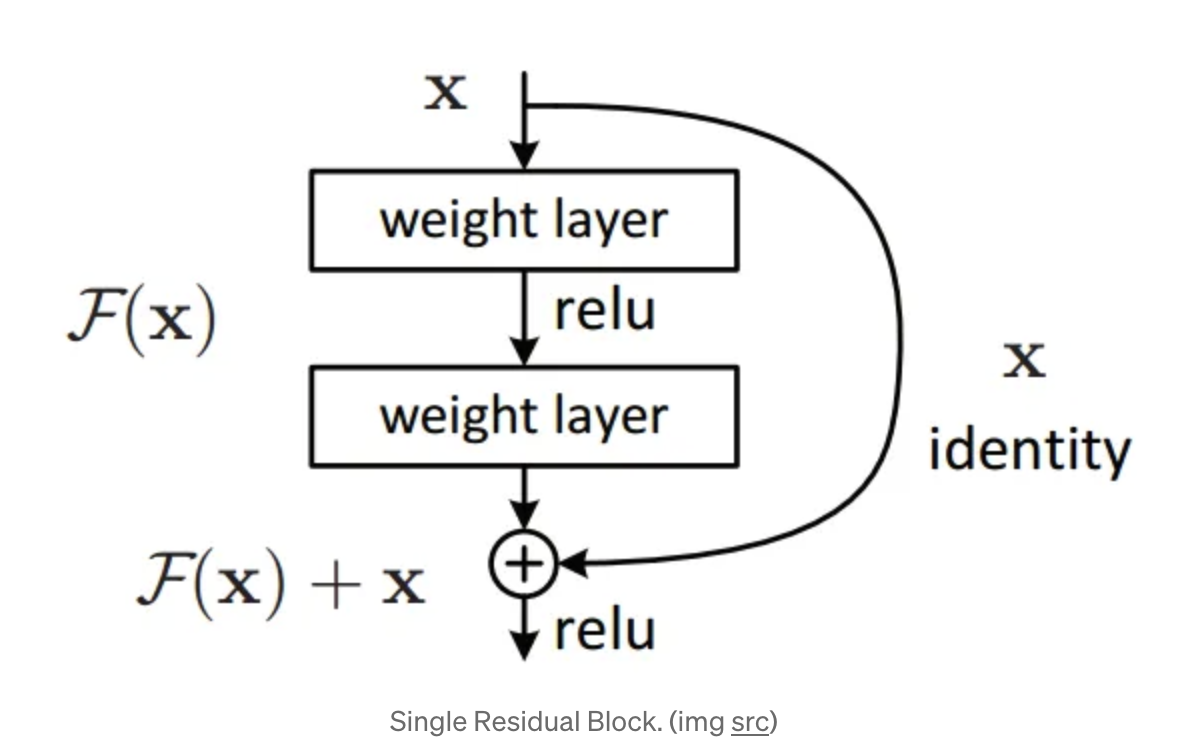

The current issues with Models is that they fail to approxmiate simple funcitions when sufficiently deep because of **vanishing gradients** and the **curse of dimensionality**. Simple shallow ones function though. So why not skip some layers to match the accuracy of the shallow ones ?

When observing the image above we notice that the network can learn the identity function by simply setting $$f(x) = 0$$

There seems to be a bunch of various implementations possible, I'm basing myself off the table from the original ResNet paper.

![CleanShot 2024-10-18 at 12.02.20@2x.png](<attachment:CleanShot 2024-10-18 at 12.02.20@2x.png>)
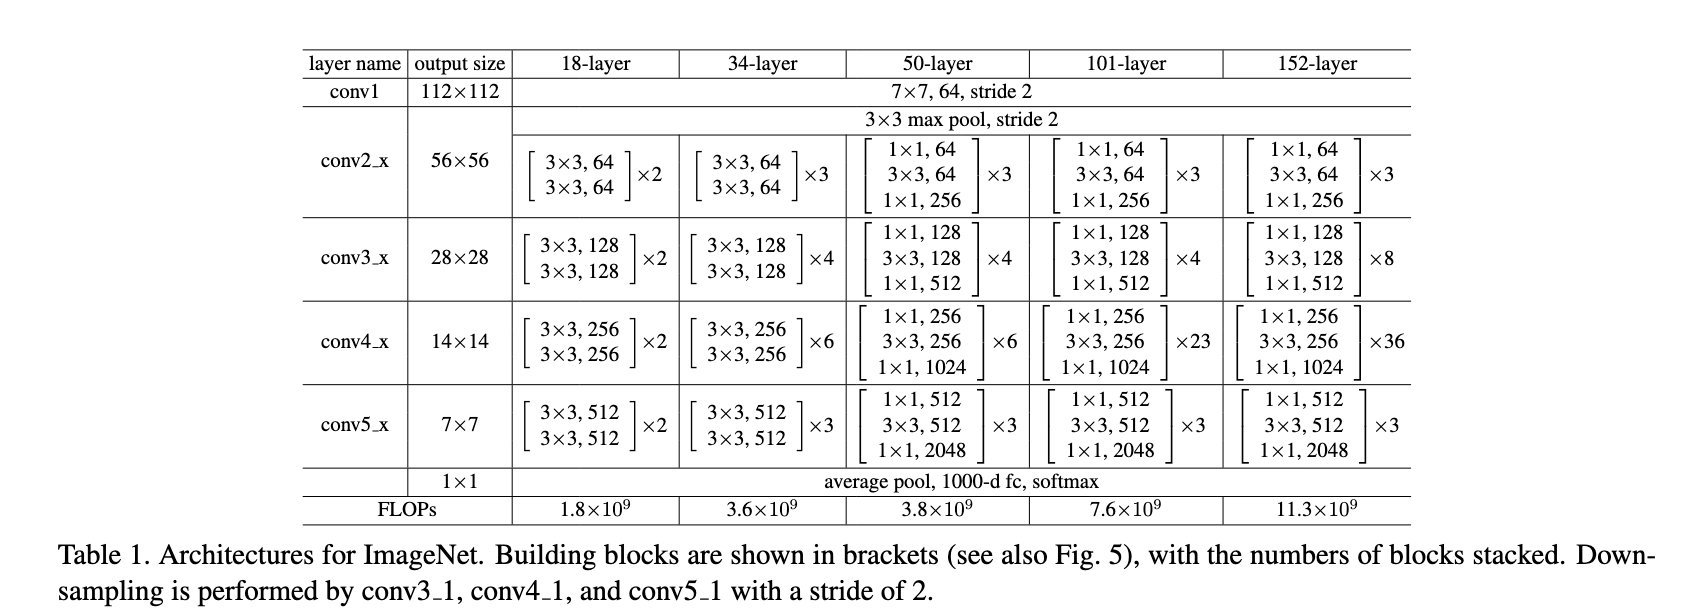

    The convolutional layers mostly have 3×3 filters and
    follow two simple design rules: (i) for the same output
    feature map size, the layers have the same number of fil-
    ters; and (ii) if the feature map size is halved, the num-
    ber of filters is doubled so as to preserve the time com-
    plexity per layer.

![CleanShot 2024-10-18 at 12.09.15@2x.png](<attachment:CleanShot 2024-10-18 at 12.09.15@2x.png>)

Explanation of the implementation for the bottleneck layers too
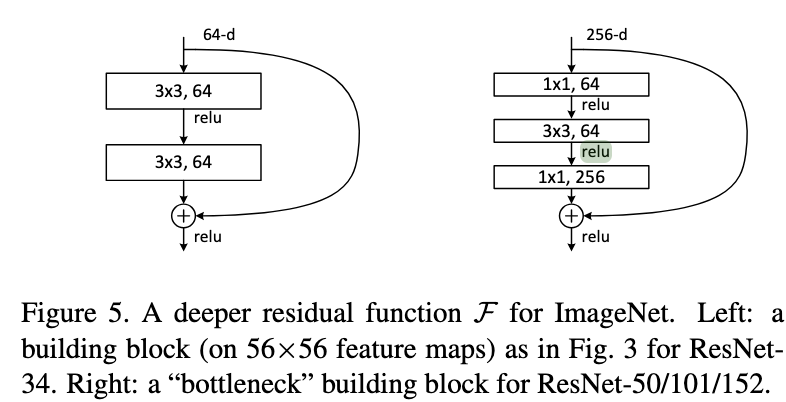

In [17]:
import jax
import equinox as eqx
from SELayer import SELayer

# https://arxiv.org/pdf/1512.03385

class SEBasicBlock(eqx.Module):
    conv1: eqx.nn.Conv2d
    conv2: eqx.nn.Conv2d
    bn1: eqx.nn.BatchNorm
    bn2: eqx.nn.BatchNorm
    se: SELayer
    downsample: None

    def __init__(self, channels_in, channels_out, stride=1, downsample=None, key=None):
        key1, key3, key5 = jax.random.split(key, 3)

        # TODO Understand why bias isn't added.
        # TODO Do we want to have a state or simply do GroupNorm instead ?

        self.conv1 = eqx.nn.Conv2d(channels_in, channels_out, kernel_size=(3, 3), stride=stride, padding=1, use_bias=False, key=key1)
        self.bn1 = eqx.nn.BatchNorm(channels_out, axis_name="batch")
        self.conv2 = eqx.nn.Conv2d(channels_out, channels_out, kernel_size=(3, 3), padding=1, use_bias=False, key=key3)
        self.bn2 = eqx.nn.BatchNorm(channels_out, axis_name="batch")

        self.se = SELayer(channels_out, key=key5)
        self.downsample = downsample

    def __call__(self, x, state):
        residual = x

        y = self.conv1(x)
        
        y = jax.nn.relu(y)
        y, state = self.bn1(y,  state)

        y = self.conv2(y)
        y, state = self.bn2(y,  state)

        y = self.se(y)

        if self.downsample is not None:
            residual, state = self.downsample(x, state)

        y = y + residual #Residual
        y = jax.nn.relu(y)

        return y, state


In [18]:
@eqx.filter_jit
def loss(model, state, x, y):
    results, state = jax.vmap(model, axis_name="batch", in_axes=(0, None), out_axes=(0, None))(x, state)

    return jax.numpy.mean((y - results) ** 2), state

loss = eqx.filter_grad(loss, has_aux=True)

key = jax.random.PRNGKey(seed = 69)
key1, key2, key3 = jax.random.split(key, 3)
x = jax.random.normal(key1, (10, 100, 256, 256)).astype(jax.numpy.float32)
y = jax.random.normal(key2, (10, 100, 256, 256)).astype(jax.numpy.float32)

model, state = eqx.nn.make_with_state(SEBasicBlock)(100, 100, 1, None, key=key3)

grads, state = loss(model, state, x, y)


(100, 256, 256)
(1, 100, 256, 256)
